### Stock Prediction - ARIMA and Auto ARIMA Model

In [1]:
# Ignore future warnings
import warnings
warnings.filterwarnings("ignore")

#import packages
import pandas as pd
import numpy as np
import os
import datetime
import pandas_datareader.data as web

#to plot within notebook
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelling
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf

In [2]:
# Data Start and end date
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2020, 12, 10)

Let's get the historical data using web. For simplicity of model, we will be using only Date and Close columns. 

In [3]:
# Get data from yahoo portal
jpm_df = web.DataReader("JPM", 'yahoo',start, end)

# Sample results
jpm_df.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,50.250000,48.083332,49.833332,48.583332,12019200.0,25.867155
2000-01-04,47.458332,46.125000,47.083332,47.250000,11723400.0,25.299580
2000-01-05,48.375000,46.000000,46.833332,46.958332,8714500.0,25.143410


In [4]:
# Check last records
jpm_df.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-08,122.330002,120.760002,121.040001,122.000000,9592100.0,121.127670
2020-12-09,123.300003,120.440002,123.169998,121.050003,13073900.0,120.184471
2020-12-10,120.779999,119.559998,119.989998,120.269997,13668400.0,119.410042


### ARIMA (AutoRegressive Integrated Moving Average) for Time Series Prediction

‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know,
work best when the predictors are not correlated and are independent of each other.

In [5]:
# Copy data frame
df = jpm_df.copy()

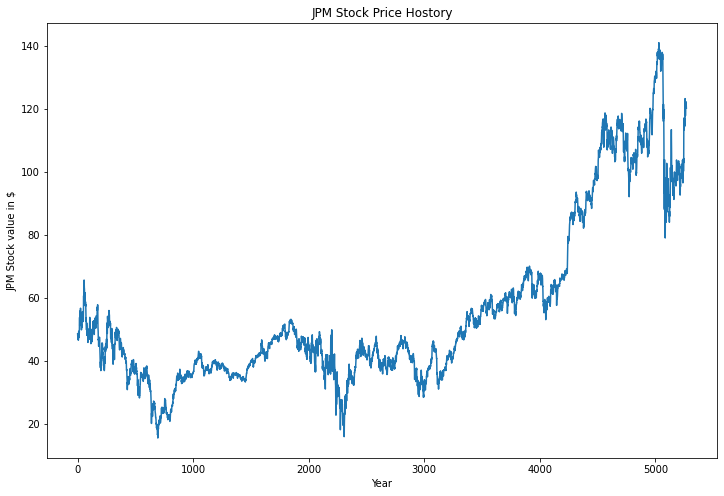

In [6]:
# Plot stock performace
plt.figure(figsize=(12,8))
plt.plot(df.Close.values)
plt.xlabel("Year")
plt.ylabel("JPM Stock value in $")
plt.title("JPM Stock Price Hostory")
plt.show()

### ARIMA Modelling

An ARIMA model is characterized by 3 terms: p, d, q where,
- p is the order of the Auro Rregressive term
- q is the order of the Moving Average term
- d is the number of differencing required to make the time series stationary

##### Let's make a series stationary:

- The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

- The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

- 'p' and 'q' terms:
    - 'p' is the order of the 'Auto Regressive' (AR) term. It refers to the number of lags of Y to be used as predictors. 
    - 'q' is the order of the 'Moving Average' (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

A pure Auto Regressive (AR only) model is one where Yt depends only on its own lags. That is, Yt is a function of the ‘lags of Yt’.
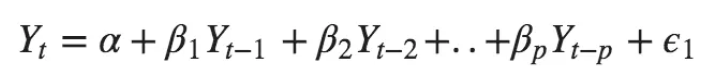
where, $Y{t-1}$ is the lag1 of the series, $\beta1$ is the coefficient of lag1 that the
model estimates and $\alpha$ is the intercept term, also estimated by the model.

Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors. 
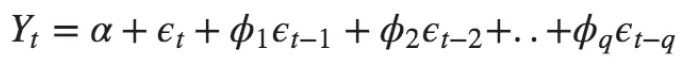

where the error terms are the errors of the autoregressive models of the respective lags. 

The errors Et and E(t-1) are the errors from the following equations :

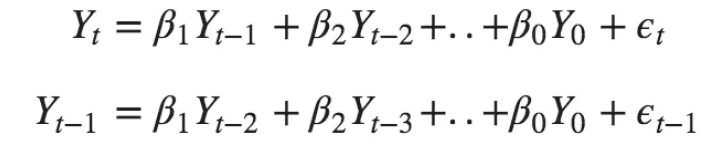

- So what does the equation of an ARIMA model look like?
    - An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:
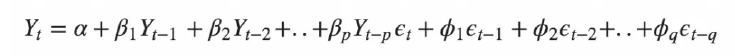

ARIMA model in words:
- Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

- The objective, therefore, is to identify the values of p, d and q. 

* How to find the order of differencing (d) in ARIMA model?

    - The purpose of differencing it to make the time series stationary. But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

* So how to determine the right order of differencing?
- The right order of differencing is the minimum differencing required to get a near stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.
- If the auto correlations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 auto correlation itself is too negative, then the series is probably over-differenced.
- In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.
- Let’s see how to do it with an example.

* First, let's check if the series is stationary using the Augmented Dickey Fuller test ( adfuller() ), from the statsmodels package.
- If no differencing is needed, then d=0.
- The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.
- So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [7]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Close.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.444955
p-value: 0.902318


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

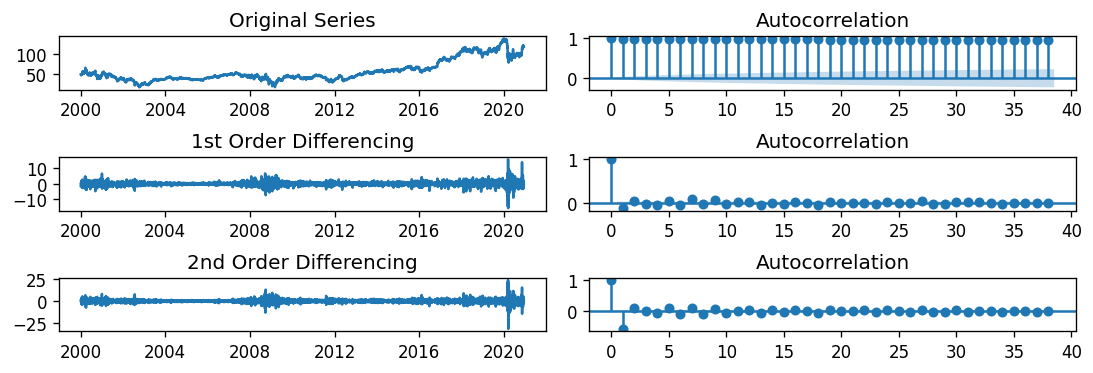

In [8]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2,constrained_layout=True)
axes[0, 0].plot(df[['Close']].dropna()); axes[0, 0].set_title('Original Series')
plot_acf(df[['Close']].dropna(), ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

For the above series, the time series reaches stationarity with one orders of differencing. So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

- The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
     - Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. 
     - So, PACF sortof conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.
    
- Now, how to find the number of AR terms?
    - Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

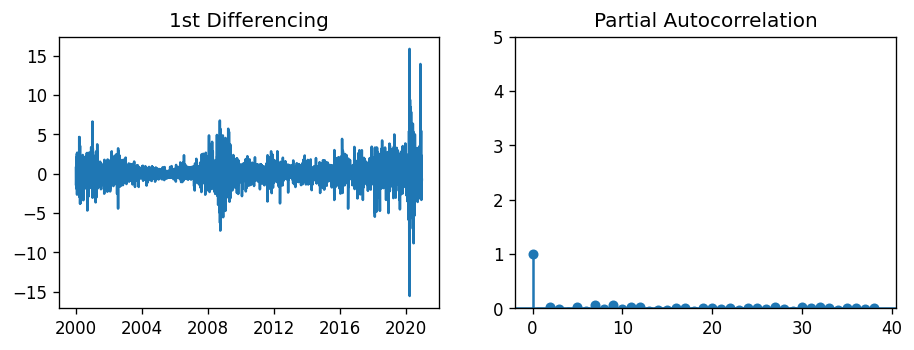

In [9]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.Close.diff().dropna(), ax=axes[1])
plt.show()

You can observe that the PACF lag 1 is well above the significance line. Let's consider value of p as 1.

- How to find the order of the MA term (q)
    - Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
    - The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series. 

- Let’s see the autocorrelation plot of the differenced series.

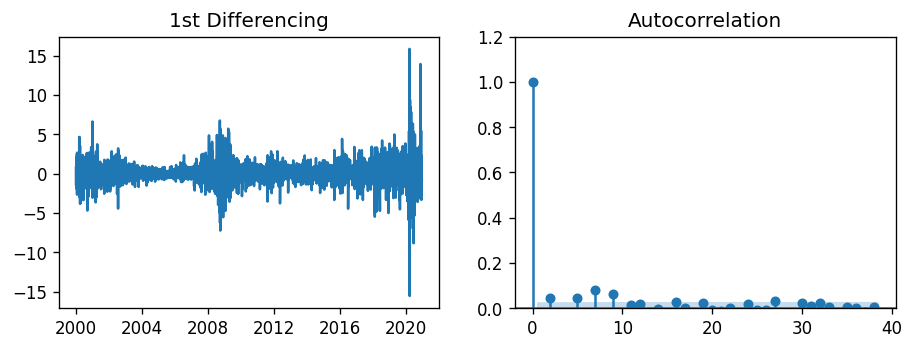

In [10]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.Close.diff().dropna(), ax=axes[1])
plt.show()

Three lags are well above the significance line. So, let’s tentatively fix q as 3. When in doubt, go with the simpler model that sufficiently explains the Y.

#### Build the ARIMA Model

Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model. Let’s use the ARIMA() implementation in statsmodels package.

In [11]:
# 1,1,3 ARIMA Model
model = ARIMA(df.Close.values, order=(1,1,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5269
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -8563.542
Method:                       css-mle   S.D. of innovations              1.229
Date:                Wed, 06 Jan 2021   AIC                          17139.084
Time:                        08:52:52   BIC                          17178.501
Sample:                             1   HQIC                         17152.862
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0136      0.016      0.853      0.393      -0.018       0.045
ar.L1.D.y     -0.8622      0.034    -25.445      0.000      -0.929      -0.796
ma.L1.D.y      0.7555      0.036     21.188      0.0

- The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.
- Notice that the P-Value in ‘P>|z|’ column is not insignificant as its less than 0.05 for the respective X to be significant.

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

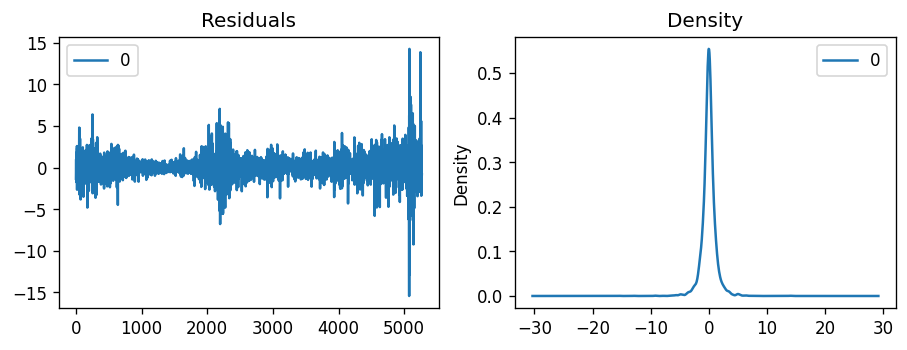

In [12]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict() .

### Auto ARIMA Model
- Let's try auto arima model to find optimal p,d and q values

In [13]:
model = pm.auto_arima(df.Close.values, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17234.582, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17158.936, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17163.940, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17233.215, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17156.277, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17157.614, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17158.150, Time=1.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17156.692, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17155.655, Time=1.69 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17104.874, Time=2.78 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=17140.619, Time=0.67 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=17106.691, Time=3.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17102.055, Time=6.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17101.744, Time=3.89 sec
 ARIMA(2,1,2)(0,0,0

#### Train and Test Model

In [14]:
# Convert dates into number of days as dates cannot be passed directly to the regression model
df.index = (df.index - pd.to_datetime('2000-01-01')).days

In [15]:
# Split data
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

In [16]:
# Get data shape
train_data.shape,test_data.shape

((4216, 6), (1054, 6))

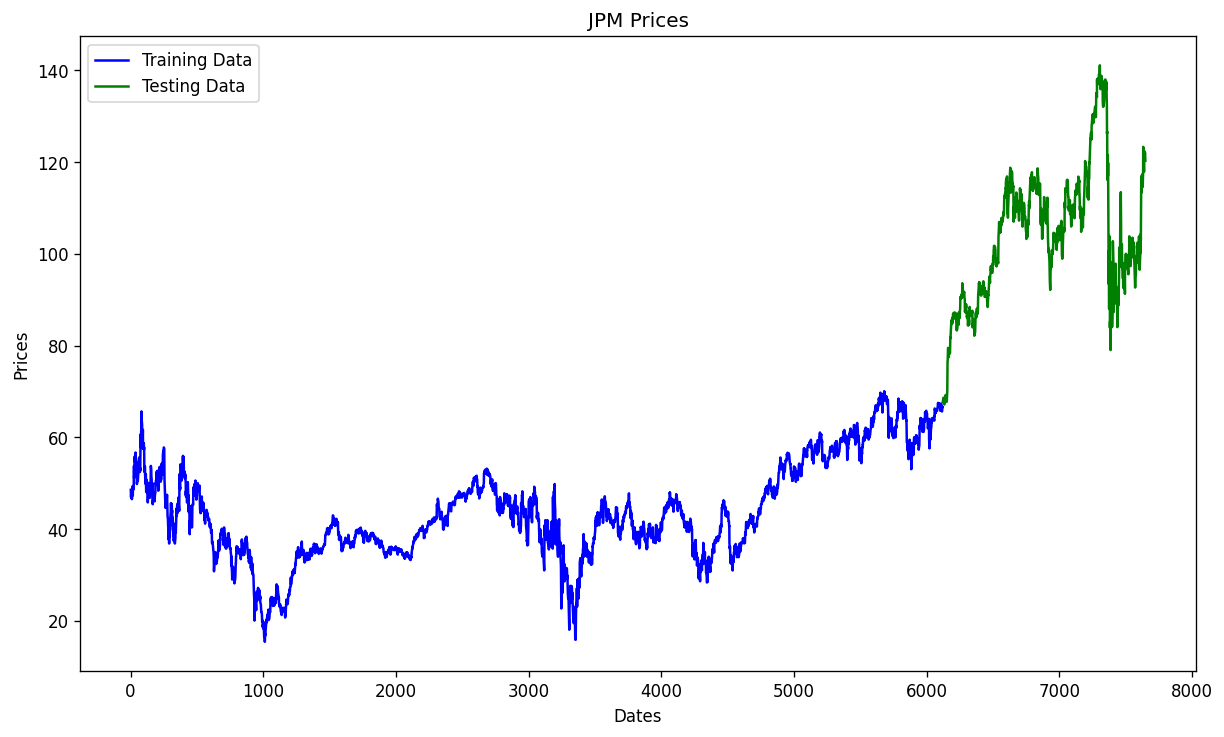

In [17]:
# Fig size
plt.figure(figsize=(12,7))

# Plot training and test actual data
plt.plot(train_data['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')

# Labels
plt.title('JPM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Display plot
plt.show()

In [18]:
# Let's predict data for next two years or 730 days (365*2). Will need to add index range for future days 
futureindex = np.asarray(pd.RangeIndex(start=test_data.index[-1], stop=test_data.index[-1] + 730))

In [19]:
# Get tarin and test feature value data
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

# Get list of Close prices from training data 
history = [x for x in train_ar]

# Empty list to store predictions
predictions = list()

# Loop through test data range - use train data actual close prices as history to compute test close price forecast
for t in range(len(test_ar)):
    #model = ARIMA(history, order=(5,1,0))
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
     
    
# Calculate MSE    
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)

C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\anuaj\Anaconda3\envs\PythonData2020_1\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverti

Testing Mean Squared Error: 3.871


In [20]:
# Predict stock value for the future dates using entire historical data
y_future = []
lower_series = []
upper_series = []

testhist = [x for x in df.Close]

# Loop through forecast time scale i.e. 2 years or 720 days range
for t in range(len(futureindex)):
    #model = ARIMA(testhist,order=(5,1,0))
    model = ARIMA(testhist,order=(2,1,2))
    model_fit = model.fit(disp=0)
    output,se, conf = model_fit.forecast()
    yhat = output[0]
    y_future.append(yhat)
    testhist.append(yhat)
    lower_series.append(pd.Series(conf[:, 0]))
    upper_series.append(pd.Series(conf[:, 1]))

In [21]:
# Get last day of future stock prediction 
lastday = pd.to_datetime(futureindex[-1], origin='2000-01-01', unit='D',errors='coerce')

In [22]:
# Print the last predicted value
print (f"JPM Closing price on {str(lastday)[:10]} would be around ${round(y_future[-1],2)}")

JPM Closing price on 2022-12-09 would be around $130.27


In [23]:
# Convert the days index back to dates index for plotting the graph 
train_data.index = pd.to_datetime(train_data.index, origin='2000-01-01', unit='D')
test_data.index = pd.to_datetime(test_data.index, origin='2000-01-01', unit='D')
future_X = pd.to_datetime(futureindex, origin='2000-01-01', unit='D')

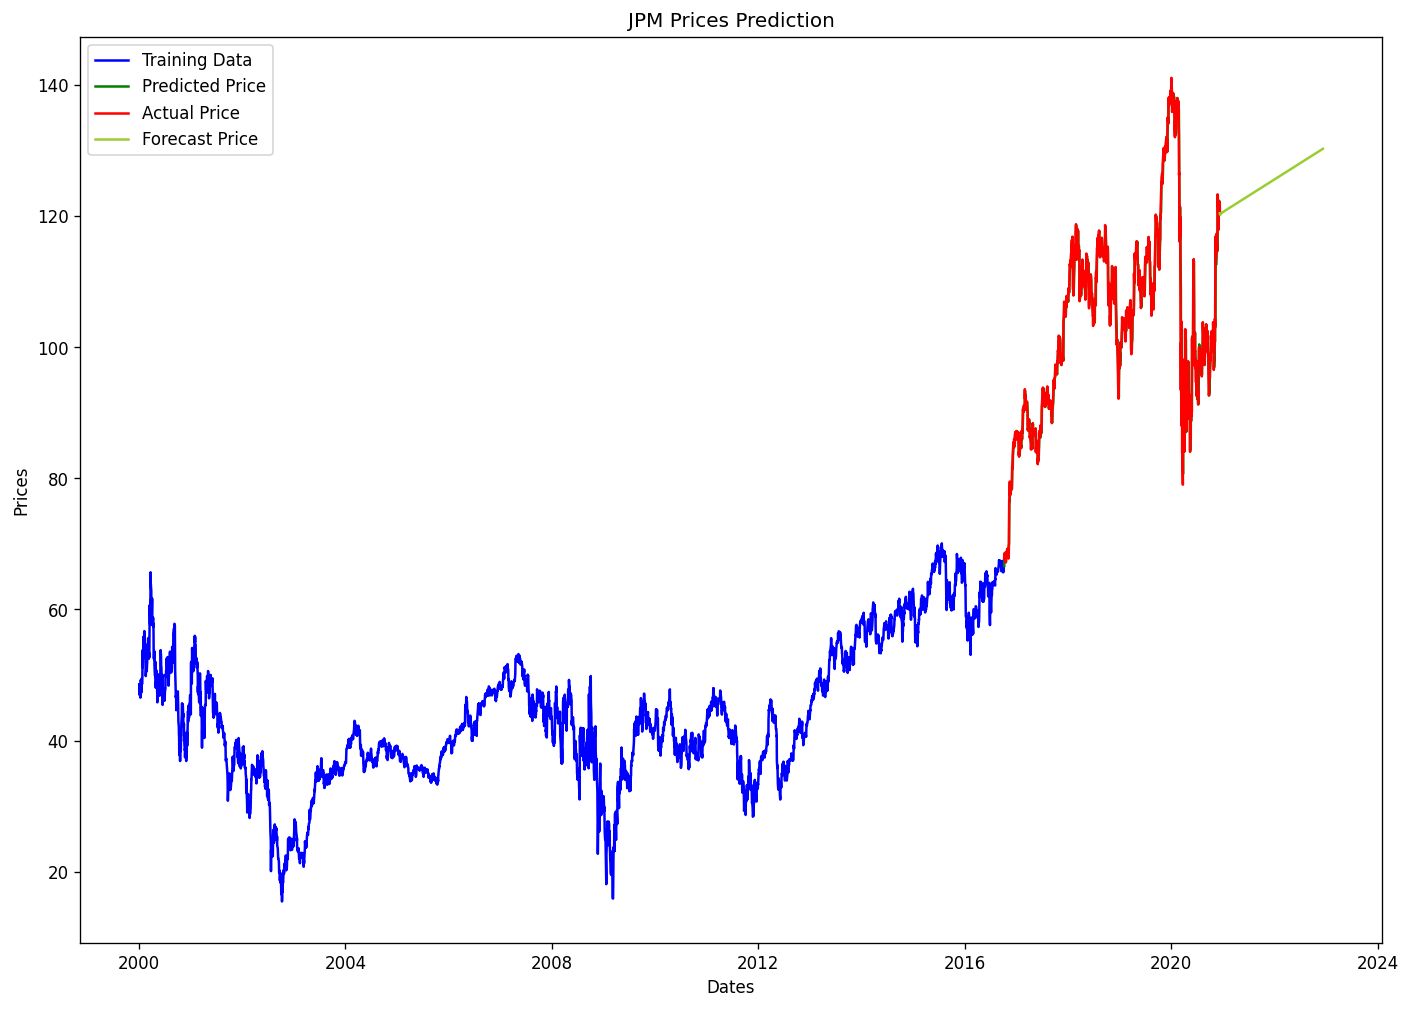

In [24]:
# Plot fig size
plt.figure(figsize=(14,10))

# Plot chart of Training, test~ predicted and forecast data
plt.plot(train_data.index,train_data['Close'], color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.plot(future_X, y_future, color='yellowgreen', label='Forecast Price')

# labels
plt.title('JPM Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Display plot
plt.show()

##### Accuracy Metrics for Time Series Forecast
The commonly used accuracy metrics to judge forecasts are:

- Mean Absolute Percentage Error (MAPE)
- Mean Error (ME)
- Mean Absolute Error (MAE)
- Mean Percentage Error (MPE)
- Root Mean Squared Error (RMSE)
- Lag 1 Autocorrelation of Error (ACF1)

In [33]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    me = np.mean(forecast - actual) # ME
    mae = np.mean(np.abs(forecast - actual)) # MAE
    mpe = np.mean((forecast - actual)/actual) # MPE
    rmse = np.mean((forecast - actual)**2)**.5 # RMSE
    
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse})

forecast_accuracy(np.array(predictions),  test_data['Close'].values)

{'mape': 0.16146665646111644,
 'me': -0.05214761464022166,
 'mae': 16.33438262390369,
 'mpe': 0.020074553368990777,
 'rmse': 20.646796891812993}

#### Conclusion:

- The graph in the blue color displays the close price history of traing data and red represents close price history of test data. Yellowgreen represents the future JPM stock price predictions for next two years.
- JPM Closing price on 2022-12-09 would be around $130.27
- Around 16.15% MAPE implies the model is about 83.85% accurate in predicting the 1054 test observations.